In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize']

[6.0, 4.0]

In [3]:
from collections import defaultdict
import logging
import pandas as pd

from sim.netrual import Component


EOS = 'EOS'
OMG = 'OMG'
USDT = 'USDT'
QTUM = 'QTUM'
ELF = 'ELF'
NTL = 'NTL'


class BotLogger:
    @classmethod
    def debug(cls, *args):
        return logging.debug(*args)

    @classmethod
    def error(cls, *args):
        return logging.error(*args)

    @classmethod
    def info(cls, *args):
        return logging.info(*args)


bot_logger = BotLogger()


def read_csv(name, type='5m'):
    return pd.read_csv(
    './csv/binance_%s_%s_kline.csv' %(name, type),
    names=[name, 'open', 'high', 'low', 'last', 'type', 'timestamp']
)


def get_usdt_price_pandas(target_symbol):
    target2eth = read_csv('%s_ETH' % target_symbol)
    eth2usdt = read_csv('ETH_USDT')
    target2eth2usdt = pd.merge(target2eth, eth2usdt, on='timestamp')
    target2eth2usdt['price_usdt'] = target2eth2usdt['last_x'] * target2eth2usdt['last_y']
    return target2eth2usdt


def get_price_with_impact_cost(min_price, premium_rate):
    return min_price * (1 + premium_rate or 0)


def get_auction_premium_rate():
    # return random.randint(1, 20) / 100.0
    return 0.03


def get_redeem_premium_rate():
    return 0.01


def get_ntl_flat_price_for_component(component_last_bid, component_flat_price):
    return component_last_bid * component_flat_price


def get_redeem_amount(ntl_total_amount):
    if ntl_total_amount > 0:
        return 1000


def is_auction_ok(current_price_of_ntl, average_price_of_ntl_per_k):
    current_price_of_ntl = get_price_with_impact_cost(
        current_price_of_ntl,
        get_auction_premium_rate()
    )
    # print("avg and current: ", average_price_of_ntl_per_k, current_price_of_ntl)
    return (
        average_price_of_ntl_per_k > current_price_of_ntl,
        (average_price_of_ntl_per_k - current_price_of_ntl) / float(
            current_price_of_ntl
        )
    )

def is_redeem_ok(current_price_of_ntl, average_price_of_ntl_per_k):
    current_price_of_ntl = get_price_with_impact_cost(
        current_price_of_ntl,
        get_redeem_premium_rate()
    )
    print("avg and current: ", average_price_of_ntl_per_k, current_price_of_ntl)
    return (
        average_price_of_ntl_per_k < current_price_of_ntl,
        (
            (current_price_of_ntl - average_price_of_ntl_per_k) / float(
                average_price_of_ntl_per_k
            )
        )
    )


class Exchange:
    num_ntl_each_round = 1000

    def __init__(self, symbols):
        """
        :type components: dict[str, sim.netrual.Component]
        """
        self.current_index = 0
        self.symbols = symbols
        self.prices = {}
        self.components = {}
        self.current_prices = defaultdict(int)
        _other_symbol = None
        for symbol in symbols:
            self.components[symbol] = Component(symbol)
            if symbol != USDT:
                _other_symbol = symbol
            else:
                continue
            self.prices[symbol] = get_usdt_price_pandas(symbol)

        self.prices[USDT] = pd.Series(
            dict(
                timestamp=self.prices[_other_symbol].timestamp,
                price_usdt=[1, ] * len(self.prices[_other_symbol]),
            )
        )

    def get_ntl_average_price_per_k(self):
        total_supply = None
        valued = 0
        for symbol, component in self.components.items():
            total_supply = component.total_supply
            flat_price = self.get_flat_price(symbol)
            valued += flat_price * component.reserve
        if total_supply == 0:
            # Maybe has bug
            return 0
        return valued / total_supply * 1000

    def get_current_price_for_symbol(self, symbol):
        component = self.components[symbol]
        flat_price = self.get_flat_price(symbol)
        return component.min_bid * float(flat_price)

    def update_kline(self):
        for symbol in self.symbols:
            component = self.components[symbol]
            prices = self.prices[symbol]
            try:
                ts = prices['timestamp'][self.current_index]
            except KeyError:
                raise ValueError("Data is gone.")
            component(ts)
            self.current_prices[symbol] = prices['price_usdt'][self.current_index]
        self.current_index += 1

    def bootstrap(self):
        for x in range(100):
            self.update_kline()
            for name, component in self.components.items():
                if name == ELF:
                    component.auction('the-god', 1 + x)
                else:
                    component.auction('the-god', 0.1 + x / 10.0)

    def get_flat_price(self, symbol):
        return self.current_prices[symbol]

    def get_ntl_min_price(self, token_name):
        component = self.components[token_name]
        return component.min_bid

    def redeem(self, symbol, sender_name, num_ntl):
        """
        return token.
        """
        component = self.components[symbol]
        _redeemed = component.redeem(sender_name, num_ntl)
        num_redeemed = 0
        ntl_cost = 0
        for redeemed in _redeemed:
            if redeemed is None:
                continue
            ntl_cost += 1000
            num_redeemed += redeemed
        # num_redeemed = _redeemed
        return num_redeemed, ntl_cost

    def buy(self, num_token, symbol, sender_name):
        """
        To buy given number of NTL buy token.
        Return num_amount of ntl if succeed, None if failed
        :param num_token: 10
        :param symbol: for example EOS
        :param sender_name: trader_name
        """
        component = self.components[symbol]
        result = component.auction(sender_name, num_token)
        if result:
            return self.num_ntl_each_round
        return None

    @classmethod
    def get_ntl_each_round(cls):
        return cls.num_ntl_each_round


class Trader:
    """
    A trader that always wants more flat-money.
    """
    name = 'greed-is-good'

    def __init__(self, symbols, assets, exchange):
        """
        :type exchange: Exchange
        """
        self.assets = assets
        self.symbols = symbols
        self.exchange = exchange

    def one_cycle(self):
        """
        Should be run each round.
        """
        redeem_result = []
        for symbol in self.symbols:
            auction_ok, rate = is_auction_ok(
                self.exchange.get_current_price_for_symbol(symbol),
                self.exchange.get_ntl_average_price_per_k(),
            )
            if auction_ok:
                self.do_transition(symbol, get_auction_premium_rate())
                continue
            redeem_ok, return_rate = is_redeem_ok(
                self.exchange.get_current_price_for_symbol(symbol),
                self.exchange.get_ntl_average_price_per_k(),
            )
            if redeem_ok:
                redeem_result.append((symbol, return_rate))
        if len(redeem_result) <= 0:
            return
        symbols, returns = list(zip(*redeem_result))
        max_return = max(returns)
        symbol = symbols[returns.index(max_return)]
        self.do_redeem(symbol, self.assets[NTL])

    def do_transition(self, source, premium_rate):
        price = self.exchange.get_ntl_min_price(source)
        price = get_price_with_impact_cost(price, premium_rate)
        source_cost = price
        assert price > 0

        if self.assets[source] < source_cost:
            bot_logger.error(
                "Source cost is too much, %s, price is %s"
                % (source_cost, price)
            )
            return False
        ntl_got = self.exchange.buy(source_cost, source, self.name)
        if ntl_got is None:
            bot_logger.error(
                "You do with %s auction at cycle: %s but got no ntl"
                % (
                    source,
                    self.exchange.components[source].cycle,
                )
            )
            return False
        self.assets[NTL] += ntl_got
        self.assets[source] -= source_cost
        bot_logger.debug("buy succeed: %s" % self.assets)
        return True

    def do_redeem(self, target, num_ntl):
        bot_logger.debug(
            "%s: redeeming, you have %s, accounts %s"
            % (
                self.exchange.components[target].cycle,
                self.assets,
                self.exchange.components[target].accounts,
            )
        )
        num_target_got, ntl_cost = self.exchange.redeem(
            target,
            self.name,
            num_ntl,
        )
        self.assets[NTL] -= ntl_cost
        self.assets[target] += num_target_got
        if num_target_got == 0:
            bot_logger.error(
                "%s: Failed to redeem, you have %s, accounts %s"
                % (
                    self.exchange.components[target].cycle,
                    self.assets,
                    self.exchange.components[target].accounts,
                )
            )
            return False
        return True


class Statistics:

    def __init__(self):
        self.ntl_prices = defaultdict(list)
        self.reversed_amounts = defaultdict(list)
        self.flat_prices = defaultdict(list)
        self.ntl_total_supply_amounts = defaultdict(list)
        self.ts = []

    def record(self, exchange):
        self.ts.append(exchange.components['EOS'].timestamp)
        for symbol in exchange.symbols:
            self.ntl_prices[symbol].append(
                exchange.components[symbol].min_bid
            )
            self.reversed_amounts[symbol].append(
                exchange.components[symbol].reserve
            )
            self.ntl_total_supply_amounts[symbol].append(
                exchange.components[symbol].total_supply
            )
            self.flat_prices[symbol].append(
                exchange.get_flat_price(symbol)
            )
        self.flat_prices[NTL].append(
            exchange.get_ntl_average_price_per_k()
        )

    def get_data_frame(self, exchange):
        data_frames = []
        for symbol in exchange.symbols:
            all_data = dict(
                (
                    (
                        'ntl_%s_price' % symbol,
                        pd.Series(
                            self.ntl_prices[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        '%s_reserved' % symbol,
                        pd.Series(
                            self.reversed_amounts[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        'ntl_total_supply_%s' % symbol,
                        pd.Series(
                            self.ntl_total_supply_amounts[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        '%s_flat_price' % symbol,
                        pd.Series(
                            [float(price) for price in self.flat_prices[symbol]],
                            index=self.ts,
                        )
                    ),
                    (
                        'ntl_flat_price_%s' % symbol,
                        pd.Series(
                            self.flat_prices[NTL],
                            index=self.ts,
                        )
                    ),
                )
            )
            data_frames.append(
                pd.DataFrame(all_data)
            )
        return data_frames



def run():
    symbols = [EOS, OMG, ELF, USDT, QTUM]
    exchange = Exchange(symbols)
    statistic_tool = Statistics()
    trader = Trader(
        symbols=symbols,
        assets={
            EOS:  1000,
            OMG: 1000,
            USDT: 1000 * 10,
            QTUM: 1000,
            ELF: 1000 * 10,
            NTL: 0,
        },
        exchange=exchange,
    )
    exchange.bootstrap()
    counter = 0
    while True:
        counter += 1
        # import time
        # time.sleep(0.1)
        try:
            exchange.update_kline()
        except ValueError:
            bot_logger.info("Has no kline data, exited.")
            break
        statistic_tool.record(exchange)
        # print('NTL price: ', statistic_tool.flat_prices[NTL][-1])
        trader.one_cycle()
    df = statistic_tool.get_data_frame(exchange)
    print(trader.assets)
    return df


def main():
    result = run()
    return result


In [4]:
result = main()


ERROR:root:You do with EOS auction at cycle: 85 but got no ntl
ERROR:root:You do with OMG auction at cycle: 85 but got no ntl
ERROR:root:You do with ELF auction at cycle: 85 but got no ntl
ERROR:root:You do with USDT auction at cycle: 85 but got no ntl
ERROR:root:You do with EOS auction at cycle: 90 but got no ntl
ERROR:root:You do with OMG auction at cycle: 90 but got no ntl
ERROR:root:You do with ELF auction at cycle: 90 but got no ntl
ERROR:root:You do with USDT auction at cycle: 90 but got no ntl
ERROR:root:You do with EOS auction at cycle: 95 but got no ntl
ERROR:root:You do with OMG auction at cycle: 95 but got no ntl
ERROR:root:You do with ELF auction at cycle: 95 but got no ntl
ERROR:root:You do with USDT auction at cycle: 95 but got no ntl
ERROR:root:You do with EOS auction at cycle: 100 but got no ntl
ERROR:root:You do with OMG auction at cycle: 100 but got no ntl


EOS:: New cycle 1
OMG:: New cycle 1
ELF:: New cycle 1
Found last Winner
sent 1000 NTL to the-god
Current balance {'the-god': 1501000}
USDT:: New cycle 1
QTUM:: New cycle 1
EOS:: New cycle 2
OMG:: New cycle 2
ELF:: New cycle 2
Found last Winner
sent 1000 NTL to the-god
Current balance {'the-god': 1502000}
USDT:: New cycle 2
QTUM:: New cycle 2
EOS:: New cycle 3
OMG:: New cycle 3
ELF:: New cycle 3
Found last Winner
sent 1000 NTL to the-god
Current balance {'the-god': 1503000}
USDT:: New cycle 3
QTUM:: New cycle 3
EOS:: New cycle 4
OMG:: New cycle 4
ELF:: New cycle 4
Found last Winner
sent 1000 NTL to the-god
Current balance {'the-god': 1504000}
USDT:: New cycle 4
QTUM:: New cycle 4
EOS:: New cycle 5
OMG:: New cycle 5
ELF:: New cycle 5
Found last Winner
sent 1000 NTL to the-god
Current balance {'the-god': 1505000}
USDT:: New cycle 5
QTUM:: New cycle 5
EOS:: New cycle 6
OMG:: New cycle 6
ELF:: New cycle 6
Found last Winner
sent 1000 NTL to the-god
Current balance {'the-god': 1506000}
USDT::

ERROR:root:You do with ELF auction at cycle: 100 but got no ntl
ERROR:root:You do with USDT auction at cycle: 100 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 100 but got no ntl
ERROR:root:You do with EOS auction at cycle: 105 but got no ntl
ERROR:root:You do with OMG auction at cycle: 105 but got no ntl
ERROR:root:You do with USDT auction at cycle: 105 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 105 but got no ntl
ERROR:root:You do with EOS auction at cycle: 110 but got no ntl
ERROR:root:You do with USDT auction at cycle: 110 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 110 but got no ntl
ERROR:root:You do with EOS auction at cycle: 115 but got no ntl
ERROR:root:You do with OMG auction at cycle: 115 but got no ntl
ERROR:root:You do with ELF auction at cycle: 115 but got no ntl
ERROR:root:You do with USDT auction at cycle: 115 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 115 but got no ntl
ERROR:root:You do with OMG aucti

EOS:: New cycle 101
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 25000}
OMG:: New cycle 101
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 26000}
ELF:: New cycle 101
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 27000}
USDT:: New cycle 101
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 28000}
QTUM:: New cycle 101
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 29000}
EOS:: New cycle 102
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 30000}
OMG:: New cycle 102
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 31000}
ELF:: New cycle 102
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'t

ERROR:root:You do with OMG auction at cycle: 155 but got no ntl
ERROR:root:You do with ELF auction at cycle: 155 but got no ntl
ERROR:root:You do with USDT auction at cycle: 155 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 155 but got no ntl
ERROR:root:You do with EOS auction at cycle: 160 but got no ntl
ERROR:root:You do with OMG auction at cycle: 160 but got no ntl
ERROR:root:You do with ELF auction at cycle: 160 but got no ntl
ERROR:root:You do with USDT auction at cycle: 160 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 160 but got no ntl
ERROR:root:You do with EOS auction at cycle: 165 but got no ntl
ERROR:root:You do with ELF auction at cycle: 165 but got no ntl
ERROR:root:You do with USDT auction at cycle: 165 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 165 but got no ntl
ERROR:root:You do with EOS auction at cycle: 170 but got no ntl
ERROR:root:You do with OMG auction at cycle: 170 but got no ntl
ERROR:root:You do with ELF auction

EOS:: New cycle 156
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 45000}
OMG:: New cycle 156
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 46000}
ELF:: New cycle 156
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 47000}
USDT:: New cycle 156
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 48000}
QTUM:: New cycle 156
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 49000}
EOS:: New cycle 157
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 50000}
OMG:: New cycle 157
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 51000}
ELF:: New cycle 157
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'t

ERROR:root:You do with OMG auction at cycle: 210 but got no ntl
ERROR:root:You do with ELF auction at cycle: 210 but got no ntl
ERROR:root:You do with USDT auction at cycle: 210 but got no ntl
ERROR:root:You do with OMG auction at cycle: 215 but got no ntl
ERROR:root:You do with ELF auction at cycle: 215 but got no ntl
ERROR:root:You do with USDT auction at cycle: 215 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 215 but got no ntl
ERROR:root:You do with EOS auction at cycle: 220 but got no ntl
ERROR:root:You do with ELF auction at cycle: 220 but got no ntl
ERROR:root:You do with USDT auction at cycle: 220 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 220 but got no ntl
ERROR:root:You do with EOS auction at cycle: 225 but got no ntl
ERROR:root:You do with OMG auction at cycle: 225 but got no ntl
ERROR:root:You do with ELF auction at cycle: 225 but got no ntl
ERROR:root:You do with USDT auction at cycle: 225 but got no ntl
ERROR:root:You do with QTUM auctio

avg and current:  245.776436339 245.07943692497383
avg and current:  245.776436339 245.0207831424746
avg and current:  245.185137243 244.31016772773071
avg and current:  245.185137243 244.76188538825534
EOS:: New cycle 211
OMG:: New cycle 211
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 20000}
ELF:: New cycle 211
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 21000}
USDT:: New cycle 211
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 22000}
QTUM:: New cycle 211
avg and current:  244.069155583 243.90409597346692
avg and current:  244.069155583 243.70891558326707
EOS:: New cycle 212
OMG:: New cycle 212
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 23000}
ELF:: New cycle 212
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-

ERROR:root:You do with EOS auction at cycle: 275 but got no ntl
ERROR:root:You do with OMG auction at cycle: 275 but got no ntl
ERROR:root:You do with ELF auction at cycle: 275 but got no ntl
ERROR:root:You do with USDT auction at cycle: 275 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 275 but got no ntl
ERROR:root:You do with EOS auction at cycle: 280 but got no ntl
ERROR:root:You do with ELF auction at cycle: 280 but got no ntl
ERROR:root:You do with USDT auction at cycle: 280 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 280 but got no ntl
ERROR:root:You do with EOS auction at cycle: 285 but got no ntl
ERROR:root:You do with OMG auction at cycle: 285 but got no ntl
ERROR:root:You do with ELF auction at cycle: 285 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 285 but got no ntl
ERROR:root:You do with OMG auction at cycle: 290 but got no ntl
ERROR:root:You do with ELF auction at cycle: 290 but got no ntl
ERROR:root:You do with USDT auction

avg and current:  196.653441301 196.69297400254945
redeeming 1000 for QTUM, reserve is 10169.810511225105
redeeming 1000 for QTUM, reserve is 10159.774493133862
redeeming 1000 for QTUM, reserve is 10150.03078624916
redeeming 1000 for QTUM, reserve is 10140.570876652364
redeeming 1000 for QTUM, reserve is 10131.386498403046
redeeming 1000 for QTUM, reserve is 10122.46962631633
redeeming 1000 for QTUM, reserve is 10113.812468950586
redeeming 1000 for QTUM, reserve is 10105.407461799377
redeeming 1000 for QTUM, reserve is 10097.2472606817
redeeming 1000 for QTUM, reserve is 10089.324735324732
redeeming 1000 for QTUM, reserve is 10081.6329631335
redeeming 1000 for QTUM, reserve is 10074.165223142012
redeeming 1000 for QTUM, reserve is 10066.914990140569
redeeming 1000 for QTUM, reserve is 10059.87592897412
redeeming 1000 for QTUM, reserve is 10053.041889006692
redeeming 1000 for QTUM, reserve is 10046.406898747055
redeeming 1000 for QTUM, reserve is 10039.965160630902
redeeming 1000 for QT

ERROR:root:You do with OMG auction at cycle: 320 but got no ntl
ERROR:root:You do with ELF auction at cycle: 320 but got no ntl
ERROR:root:You do with USDT auction at cycle: 320 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 320 but got no ntl
ERROR:root:You do with EOS auction at cycle: 325 but got no ntl
ERROR:root:You do with OMG auction at cycle: 325 but got no ntl
ERROR:root:You do with ELF auction at cycle: 325 but got no ntl
ERROR:root:You do with USDT auction at cycle: 325 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 325 but got no ntl
ERROR:root:You do with EOS auction at cycle: 330 but got no ntl
ERROR:root:You do with OMG auction at cycle: 330 but got no ntl
ERROR:root:You do with ELF auction at cycle: 330 but got no ntl
ERROR:root:You do with USDT auction at cycle: 330 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 330 but got no ntl
ERROR:root:You do with EOS auction at cycle: 335 but got no ntl
ERROR:root:You do with OMG auction

EOS:: New cycle 321
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 5000}
OMG:: New cycle 321
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 6000}
ELF:: New cycle 321
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 7000}
USDT:: New cycle 321
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 8000}
QTUM:: New cycle 321
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 9000}
EOS:: New cycle 322
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 10000}
OMG:: New cycle 322
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 11000}
ELF:: New cycle 322
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-go

ERROR:root:You do with QTUM auction at cycle: 375 but got no ntl
ERROR:root:You do with EOS auction at cycle: 380 but got no ntl
ERROR:root:You do with OMG auction at cycle: 380 but got no ntl
ERROR:root:You do with ELF auction at cycle: 380 but got no ntl
ERROR:root:You do with USDT auction at cycle: 380 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 380 but got no ntl
ERROR:root:You do with EOS auction at cycle: 385 but got no ntl
ERROR:root:You do with OMG auction at cycle: 385 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 385 but got no ntl
ERROR:root:You do with EOS auction at cycle: 390 but got no ntl
ERROR:root:You do with OMG auction at cycle: 390 but got no ntl
ERROR:root:You do with ELF auction at cycle: 390 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 390 but got no ntl
ERROR:root:You do with EOS auction at cycle: 395 but got no ntl
ERROR:root:You do with OMG auction at cycle: 395 but got no ntl
ERROR:root:You do with ELF auction 

EOS:: New cycle 376
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 5000}
OMG:: New cycle 376
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 6000}
ELF:: New cycle 376
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 7000}
USDT:: New cycle 376
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 8000}
QTUM:: New cycle 376
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 9000}
EOS:: New cycle 377
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 10000}
OMG:: New cycle 377
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 11000}
ELF:: New cycle 377
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-go

ERROR:root:You do with QTUM auction at cycle: 430 but got no ntl
ERROR:root:You do with EOS auction at cycle: 435 but got no ntl
ERROR:root:You do with OMG auction at cycle: 435 but got no ntl
ERROR:root:You do with ELF auction at cycle: 435 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 435 but got no ntl
ERROR:root:You do with EOS auction at cycle: 440 but got no ntl
ERROR:root:You do with OMG auction at cycle: 440 but got no ntl
ERROR:root:You do with ELF auction at cycle: 440 but got no ntl
ERROR:root:You do with USDT auction at cycle: 440 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 440 but got no ntl
ERROR:root:You do with EOS auction at cycle: 445 but got no ntl
ERROR:root:You do with OMG auction at cycle: 445 but got no ntl
ERROR:root:You do with ELF auction at cycle: 445 but got no ntl
ERROR:root:You do with USDT auction at cycle: 445 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 445 but got no ntl
ERROR:root:You do with OMG auction

EOS:: New cycle 431
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 5000}
OMG:: New cycle 431
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 6000}
ELF:: New cycle 431
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 7000}
USDT:: New cycle 431
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 8000}
QTUM:: New cycle 431
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 9000}
EOS:: New cycle 432
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 10000}
OMG:: New cycle 432
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 11000}
ELF:: New cycle 432
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-go

ERROR:root:You do with ELF auction at cycle: 485 but got no ntl
ERROR:root:You do with USDT auction at cycle: 485 but got no ntl
ERROR:root:You do with EOS auction at cycle: 490 but got no ntl
ERROR:root:You do with OMG auction at cycle: 490 but got no ntl
ERROR:root:You do with ELF auction at cycle: 490 but got no ntl
ERROR:root:You do with USDT auction at cycle: 490 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 490 but got no ntl
ERROR:root:You do with EOS auction at cycle: 495 but got no ntl
ERROR:root:You do with OMG auction at cycle: 495 but got no ntl
ERROR:root:You do with ELF auction at cycle: 495 but got no ntl
ERROR:root:You do with USDT auction at cycle: 495 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 495 but got no ntl
ERROR:root:You do with EOS auction at cycle: 500 but got no ntl
ERROR:root:You do with OMG auction at cycle: 500 but got no ntl
ERROR:root:You do with USDT auction at cycle: 500 but got no ntl
ERROR:root:You do with QTUM auctio

avg and current:  205.300707156 205.2672194369469
EOS:: New cycle 486
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 32000}
OMG:: New cycle 486
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 33000}
ELF:: New cycle 486
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 34000}
USDT:: New cycle 486
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 35000}
QTUM:: New cycle 486
avg and current:  203.864079878 204.34051482499538
redeeming 1000 for QTUM, reserve is 10049.653067437515
redeeming 1000 for QTUM, reserve is 10039.623007529484
redeeming 1000 for QTUM, reserve is 10029.885085288677
redeeming 1000 for QTUM, reserve is 10020.430791851
redeeming 1000 for QTUM, reserve is 10011.251866183353
redeeming 1000 for QTUM, reserve is 10002.340287865249
redeeming 1000 for QTUM, reser

ERROR:root:You do with EOS auction at cycle: 540 but got no ntl
ERROR:root:You do with OMG auction at cycle: 540 but got no ntl
ERROR:root:You do with ELF auction at cycle: 540 but got no ntl
ERROR:root:You do with OMG auction at cycle: 545 but got no ntl
ERROR:root:You do with ELF auction at cycle: 545 but got no ntl
ERROR:root:You do with USDT auction at cycle: 545 but got no ntl
ERROR:root:You do with EOS auction at cycle: 550 but got no ntl
ERROR:root:You do with OMG auction at cycle: 550 but got no ntl
ERROR:root:You do with ELF auction at cycle: 550 but got no ntl
ERROR:root:You do with USDT auction at cycle: 550 but got no ntl
ERROR:root:You do with EOS auction at cycle: 555 but got no ntl
ERROR:root:You do with OMG auction at cycle: 555 but got no ntl
ERROR:root:You do with ELF auction at cycle: 555 but got no ntl
ERROR:root:You do with USDT auction at cycle: 555 but got no ntl
ERROR:root:You do with EOS auction at cycle: 560 but got no ntl
ERROR:root:You do with OMG auction at

Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 53000}
ELF:: New cycle 540
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 54000}
USDT:: New cycle 540
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 55000}
QTUM:: New cycle 540
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 56000}
avg and current:  228.727823368 231.7753216941601
avg and current:  228.727823368 228.44998138521183
redeeming 1000 for USDT, reserve is 14921.901482416006
redeeming 1000 for USDT, reserve is 14692.420965887135
redeeming 1000 for USDT, reserve is 14469.62434789794
redeeming 1000 for USDT, reserve is 14253.316951791925
redeeming 1000 for USDT, reserve is 14043.309771106473
redeeming 1000 for USDT, reserve is 13839.419304421568
redeeming 1000 for USDT, reserve is 13641.467395018748
redeeming 100

ERROR:root:You do with QTUM auction at cycle: 595 but got no ntl
ERROR:root:You do with EOS auction at cycle: 600 but got no ntl
ERROR:root:You do with OMG auction at cycle: 600 but got no ntl
ERROR:root:You do with ELF auction at cycle: 600 but got no ntl
ERROR:root:You do with USDT auction at cycle: 600 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 600 but got no ntl
ERROR:root:You do with EOS auction at cycle: 605 but got no ntl
ERROR:root:You do with OMG auction at cycle: 605 but got no ntl
ERROR:root:You do with ELF auction at cycle: 605 but got no ntl
ERROR:root:You do with USDT auction at cycle: 605 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 605 but got no ntl
ERROR:root:You do with EOS auction at cycle: 610 but got no ntl
ERROR:root:You do with ELF auction at cycle: 610 but got no ntl
ERROR:root:You do with USDT auction at cycle: 610 but got no ntl
ERROR:root:You do with QTUM auction at cycle: 610 but got no ntl
ERROR:root:You do with EOS auctio

EOS:: New cycle 596
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 1000}
OMG:: New cycle 596
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 2000}
ELF:: New cycle 596
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 3000}
USDT:: New cycle 596
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 4000}
QTUM:: New cycle 596
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 5000}
EOS:: New cycle 597
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 6000}
OMG:: New cycle 597
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god': 1887000, 'greed-is-good': 7000}
ELF:: New cycle 597
Found last Winner
sent 1000 NTL to greed-is-good
Current balance {'the-god'

{'EOS': 1004.4025749055447, 'OMG': 934.7279743155656, 'USDT': 3744.9363532393795, 'QTUM': 1158.9980030656254, 'ELF': 11278.426895556977, 'NTL': 92000}


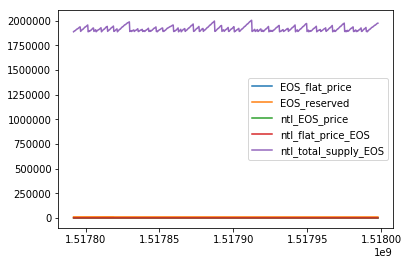

In [5]:
result[0].plot()


In [6]:
print(len(result))

5


/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


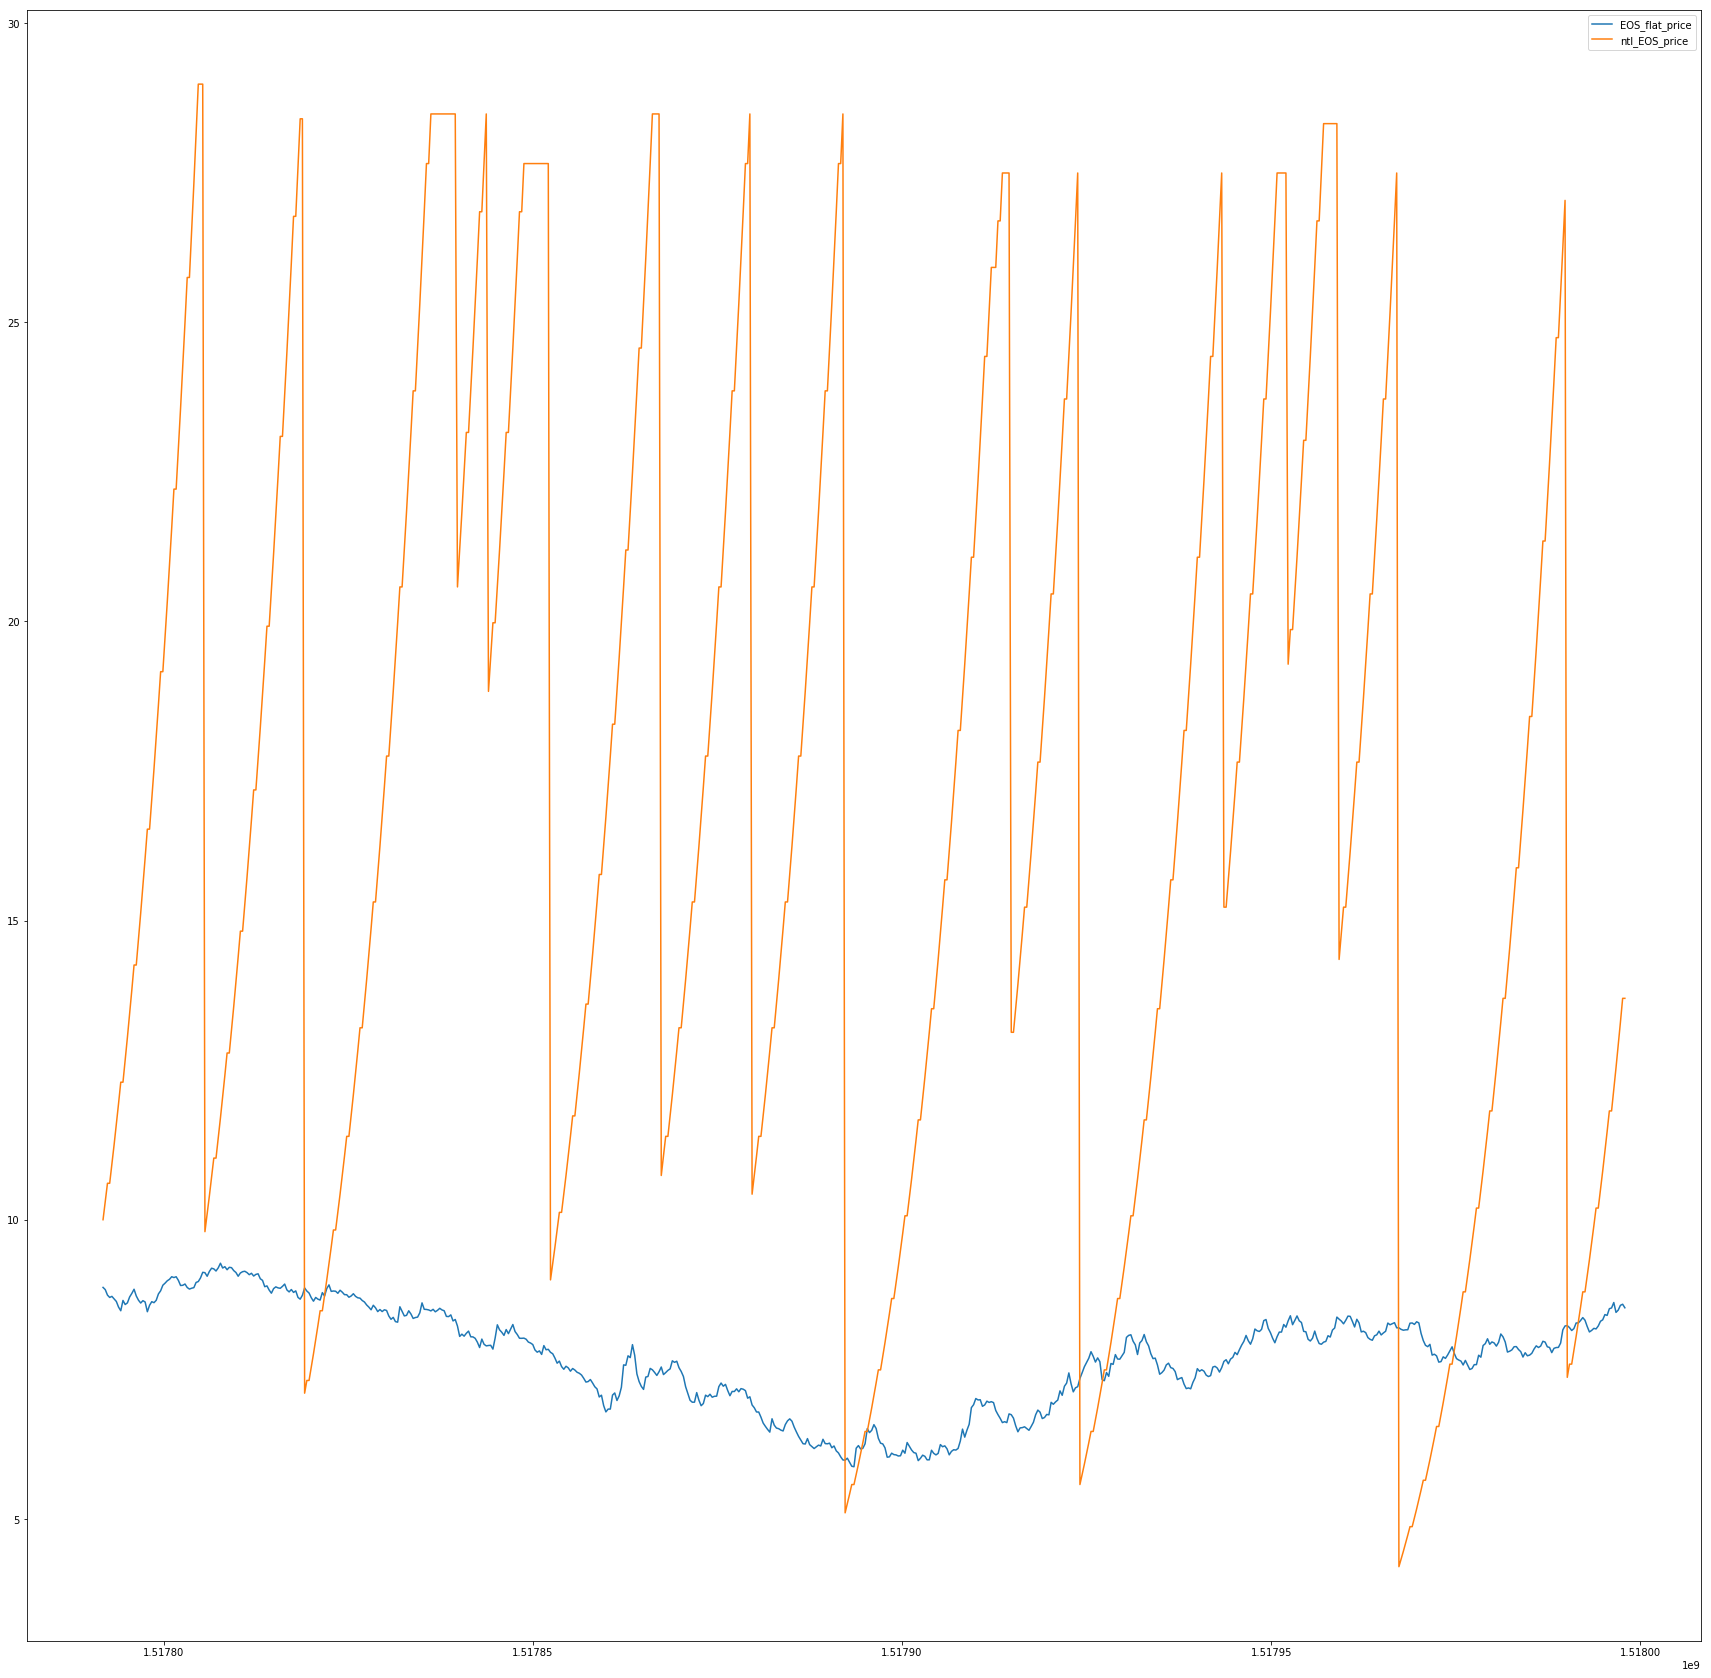

In [7]:
result[0].plot(y=['EOS_flat_price', 'ntl_EOS_price'], figsize=(30, 30))

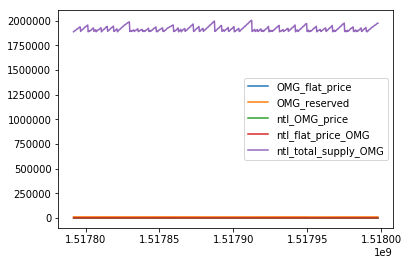

In [8]:
result[1].plot()

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


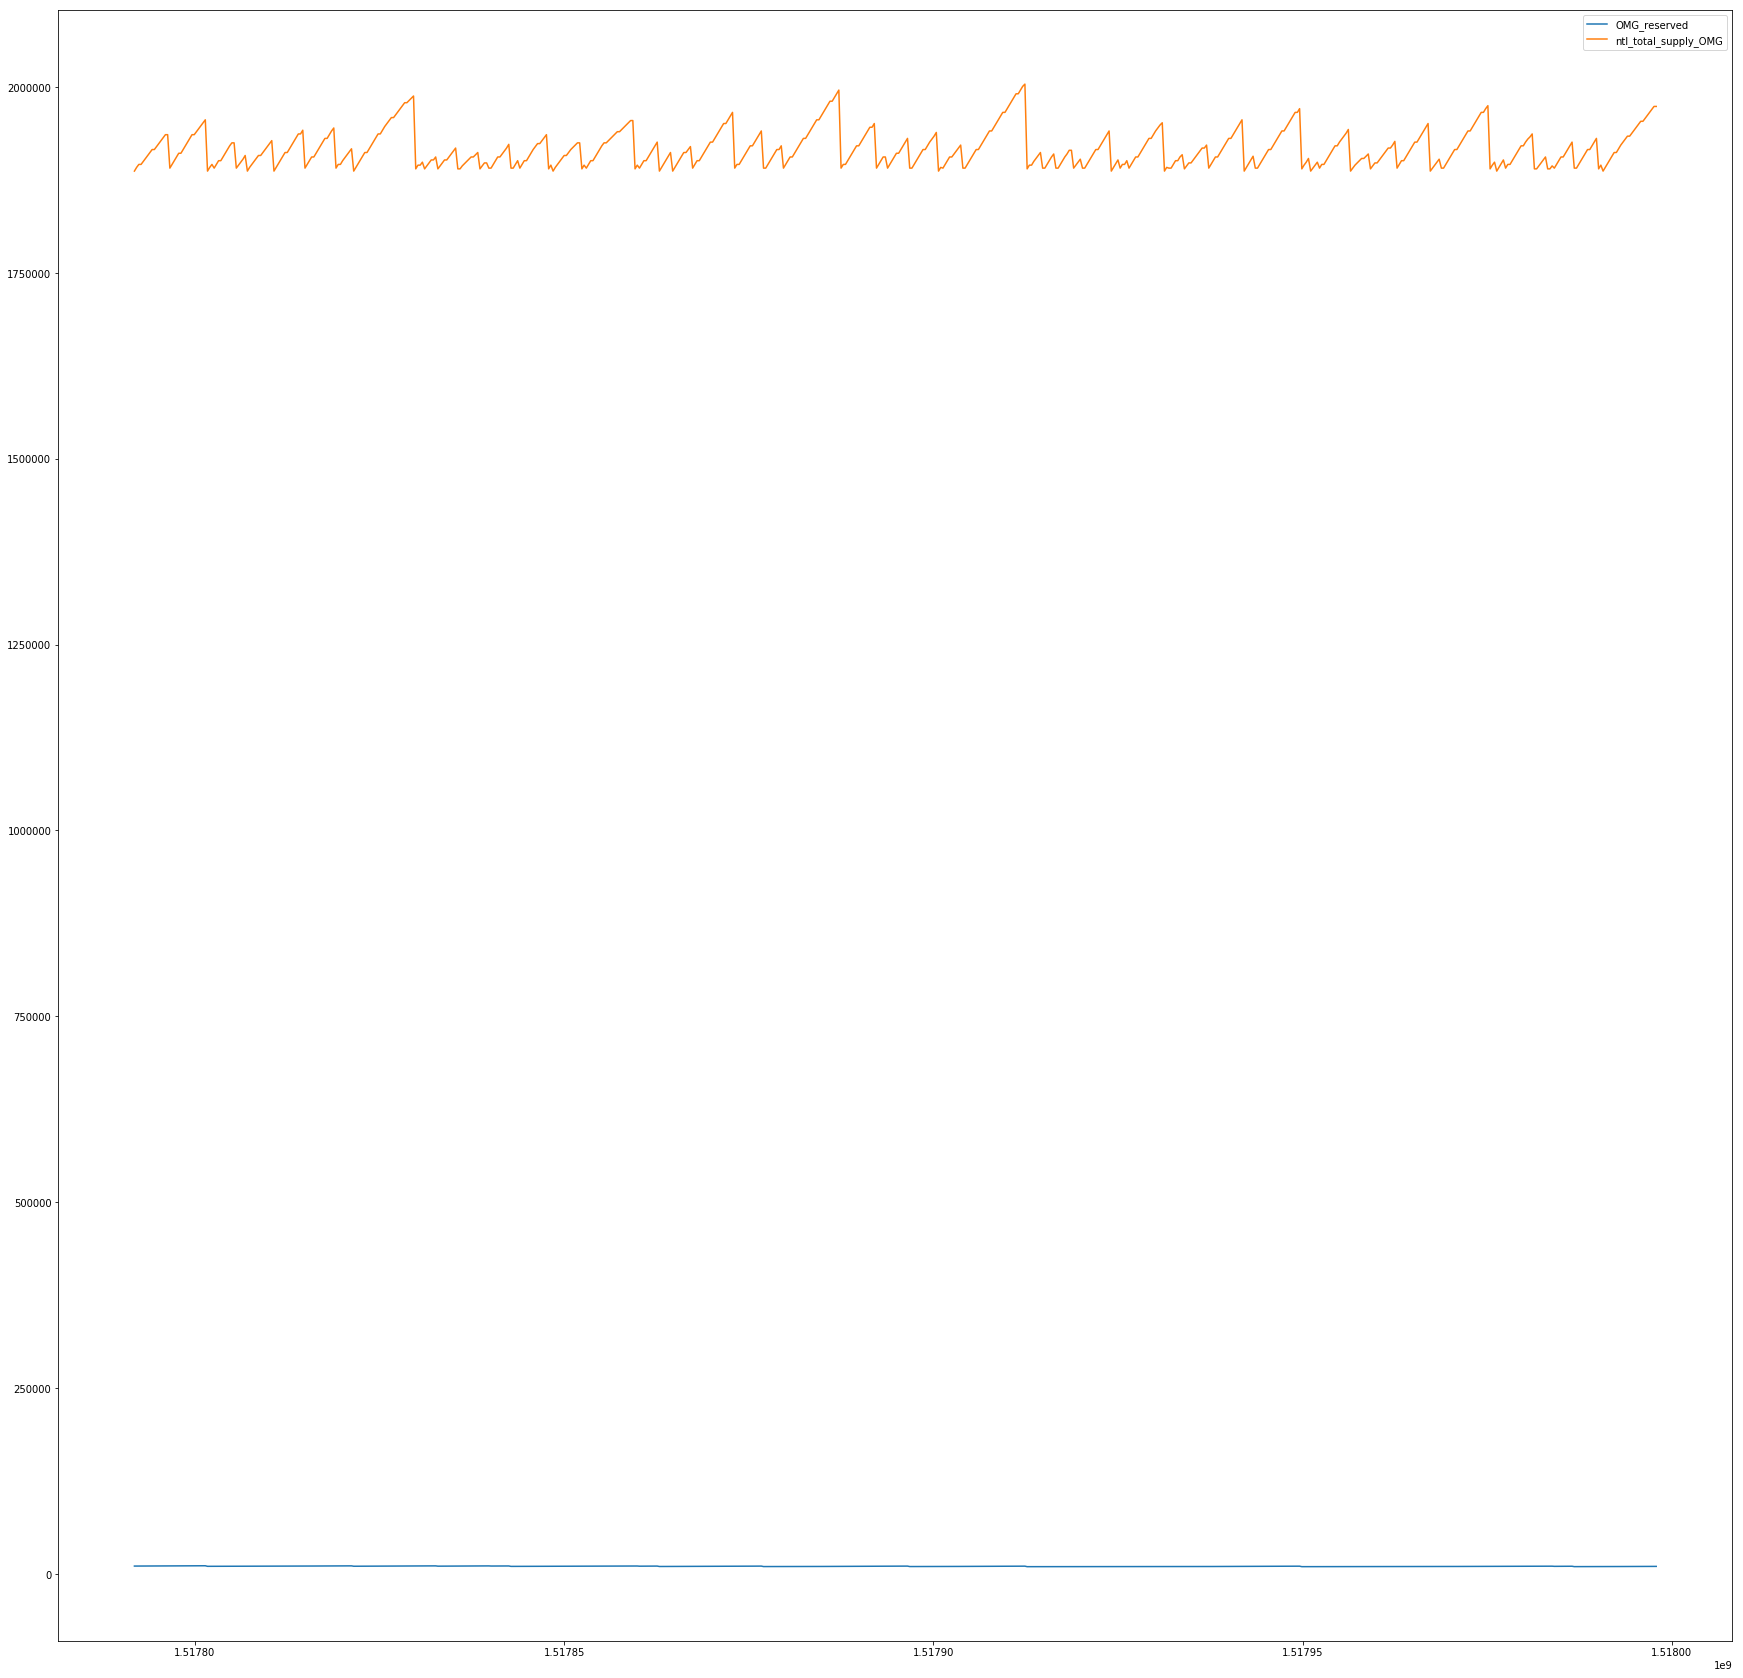

In [9]:
result[1].plot(y=['OMG_reserved', 'ntl_total_supply_OMG'], figsize=(30, 30))

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


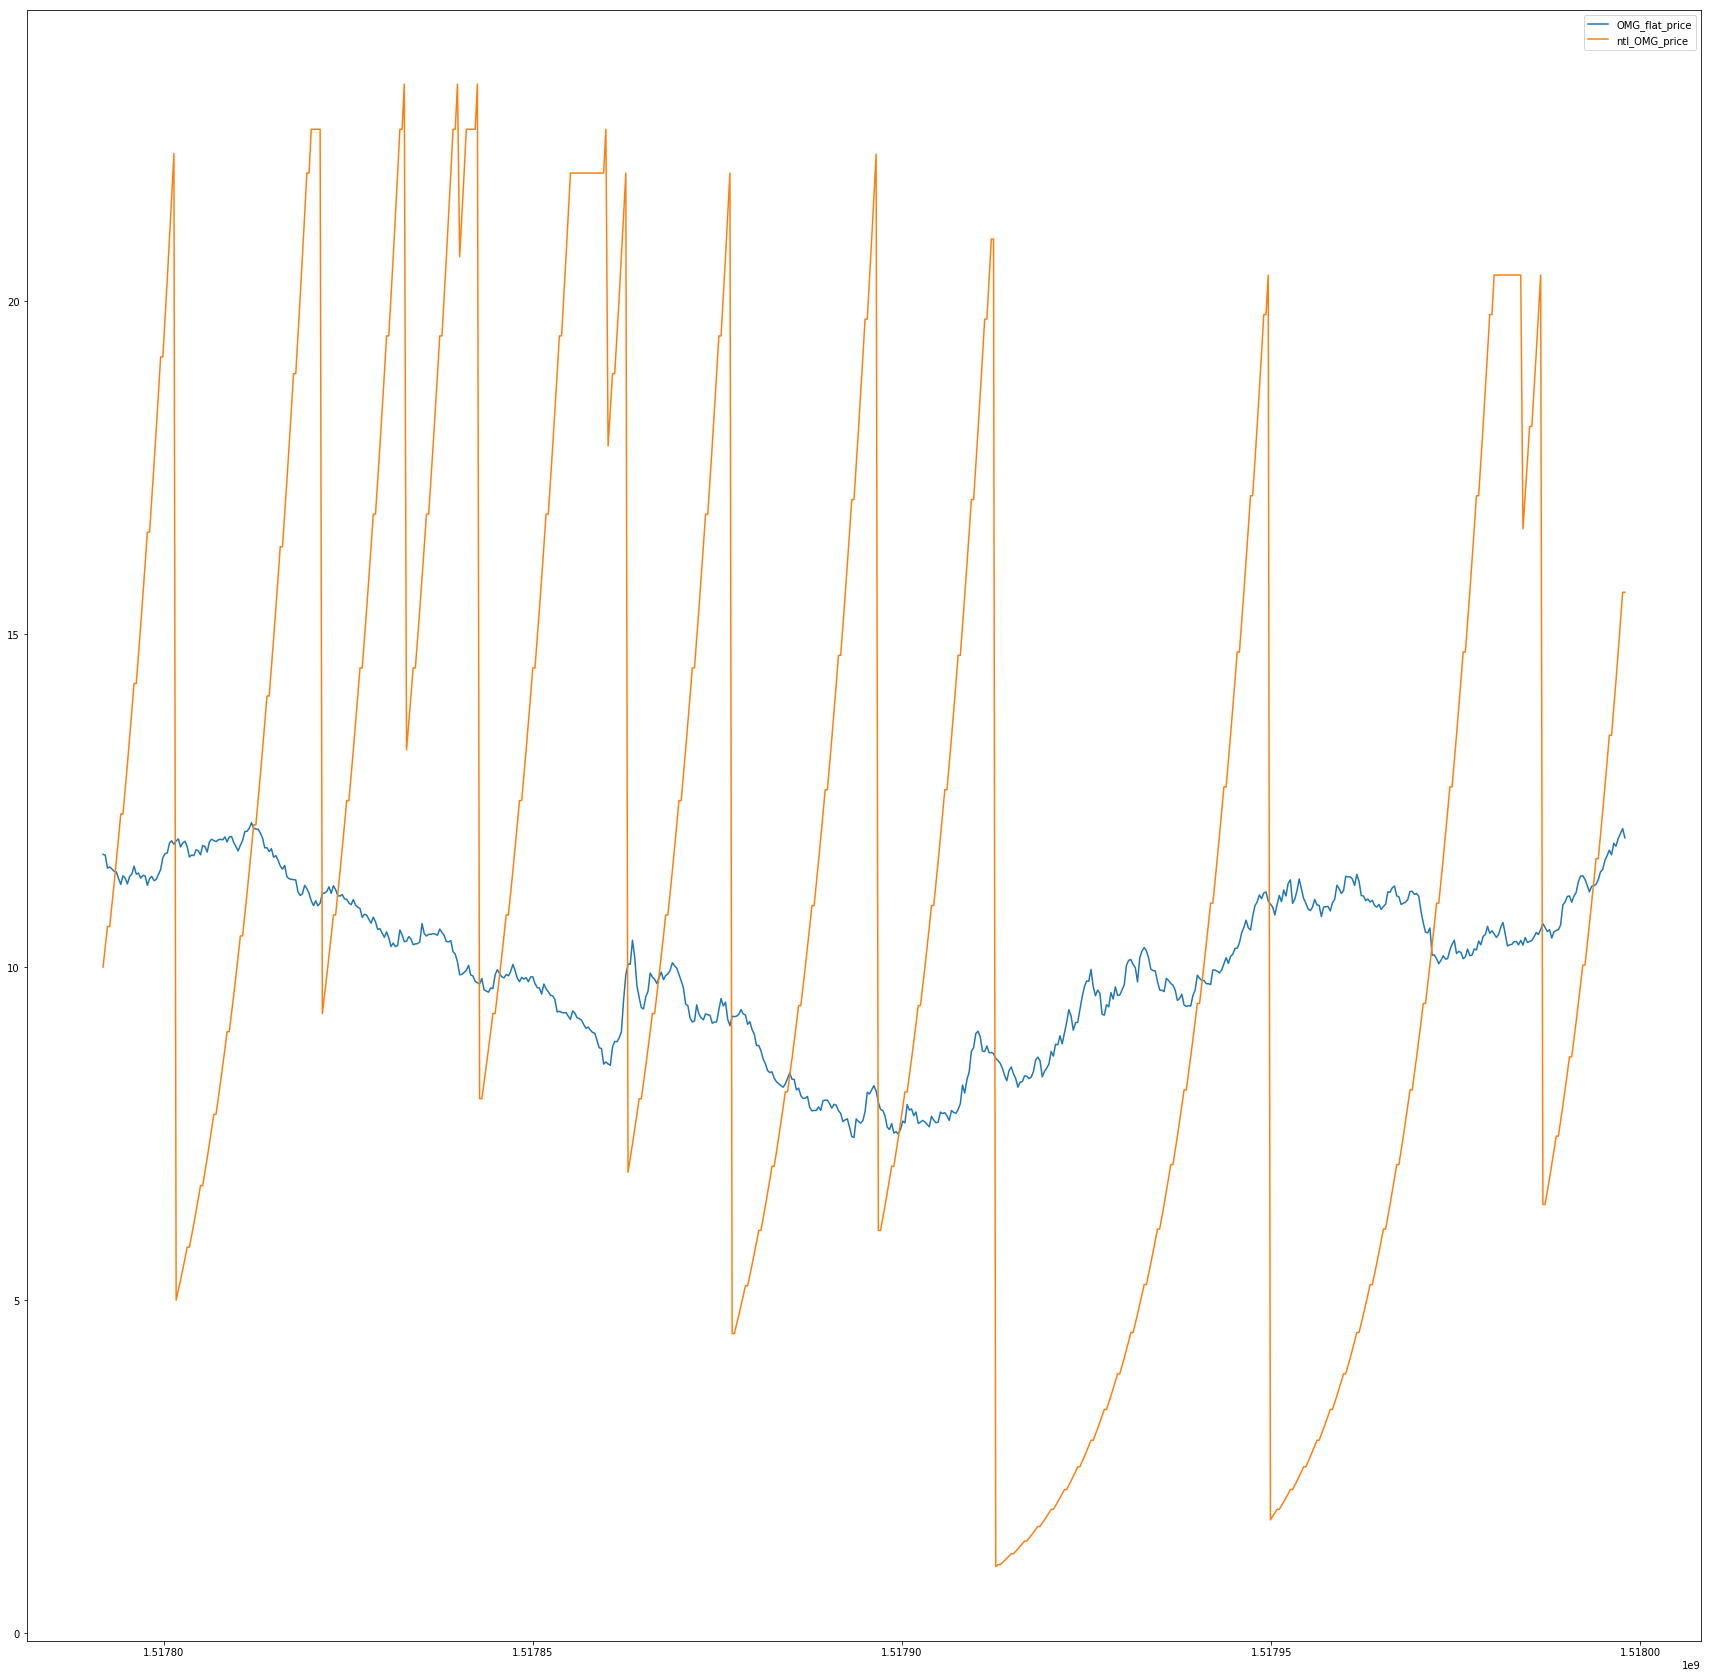

In [10]:
result[1].plot(y=['OMG_flat_price', 'ntl_OMG_price'], figsize=(30, 30))

In [11]:
concated = pd.merge(result[0], result[1], left_index=True, right_index=True)
for index in range(2, 4):
    concated = pd.merge(concated, result[index], left_index=True, right_index=True)


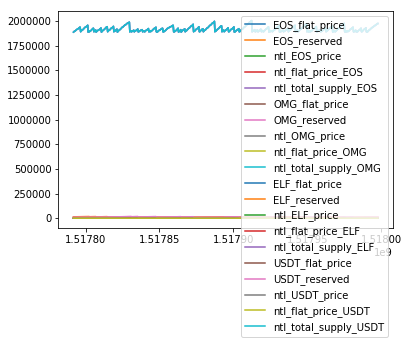

In [12]:
concated.plot()

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


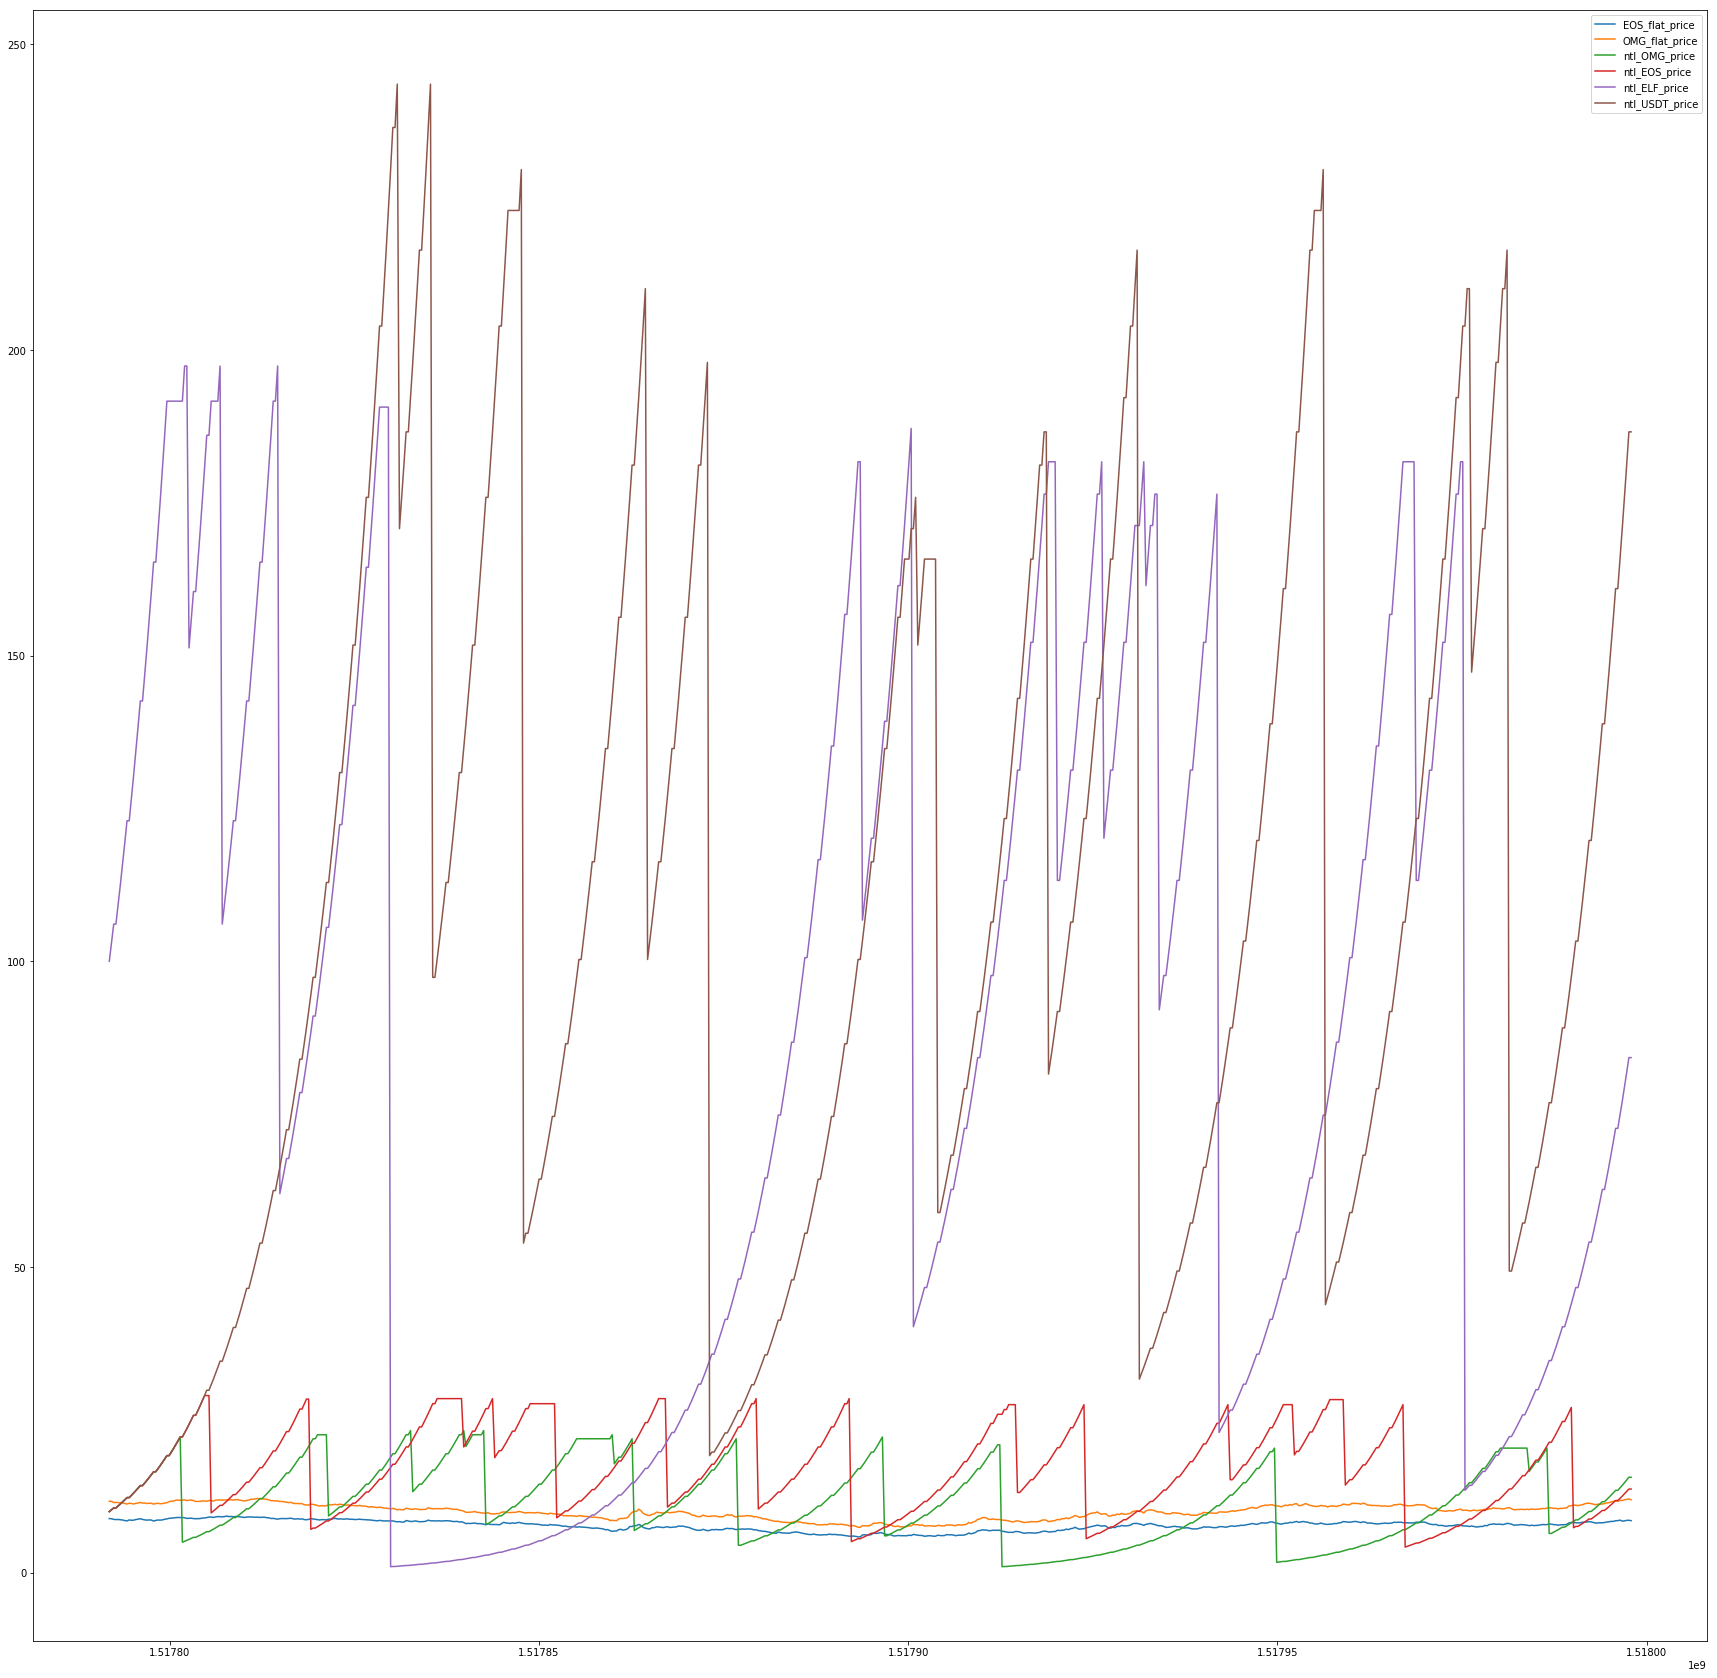

In [13]:
y = ['EOS_flat_price', 'OMG_flat_price']
y = [
    'EOS_flat_price',
    'OMG_flat_price', 
    'ntl_OMG_price', 
    'ntl_EOS_price',
    'ntl_ELF_price', 
    'ntl_USDT_price', 
#    'ntl_QTUM_price',
]
concated.plot(y=y, figsize=(30, 30))

In [14]:
concated['ntl_EOS_flat_price'] = concated['ntl_EOS_price'] * concated['EOS_flat_price'] 
concated['ntl_OMG_flat_price'] = concated['ntl_OMG_price'] * concated['OMG_flat_price']

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


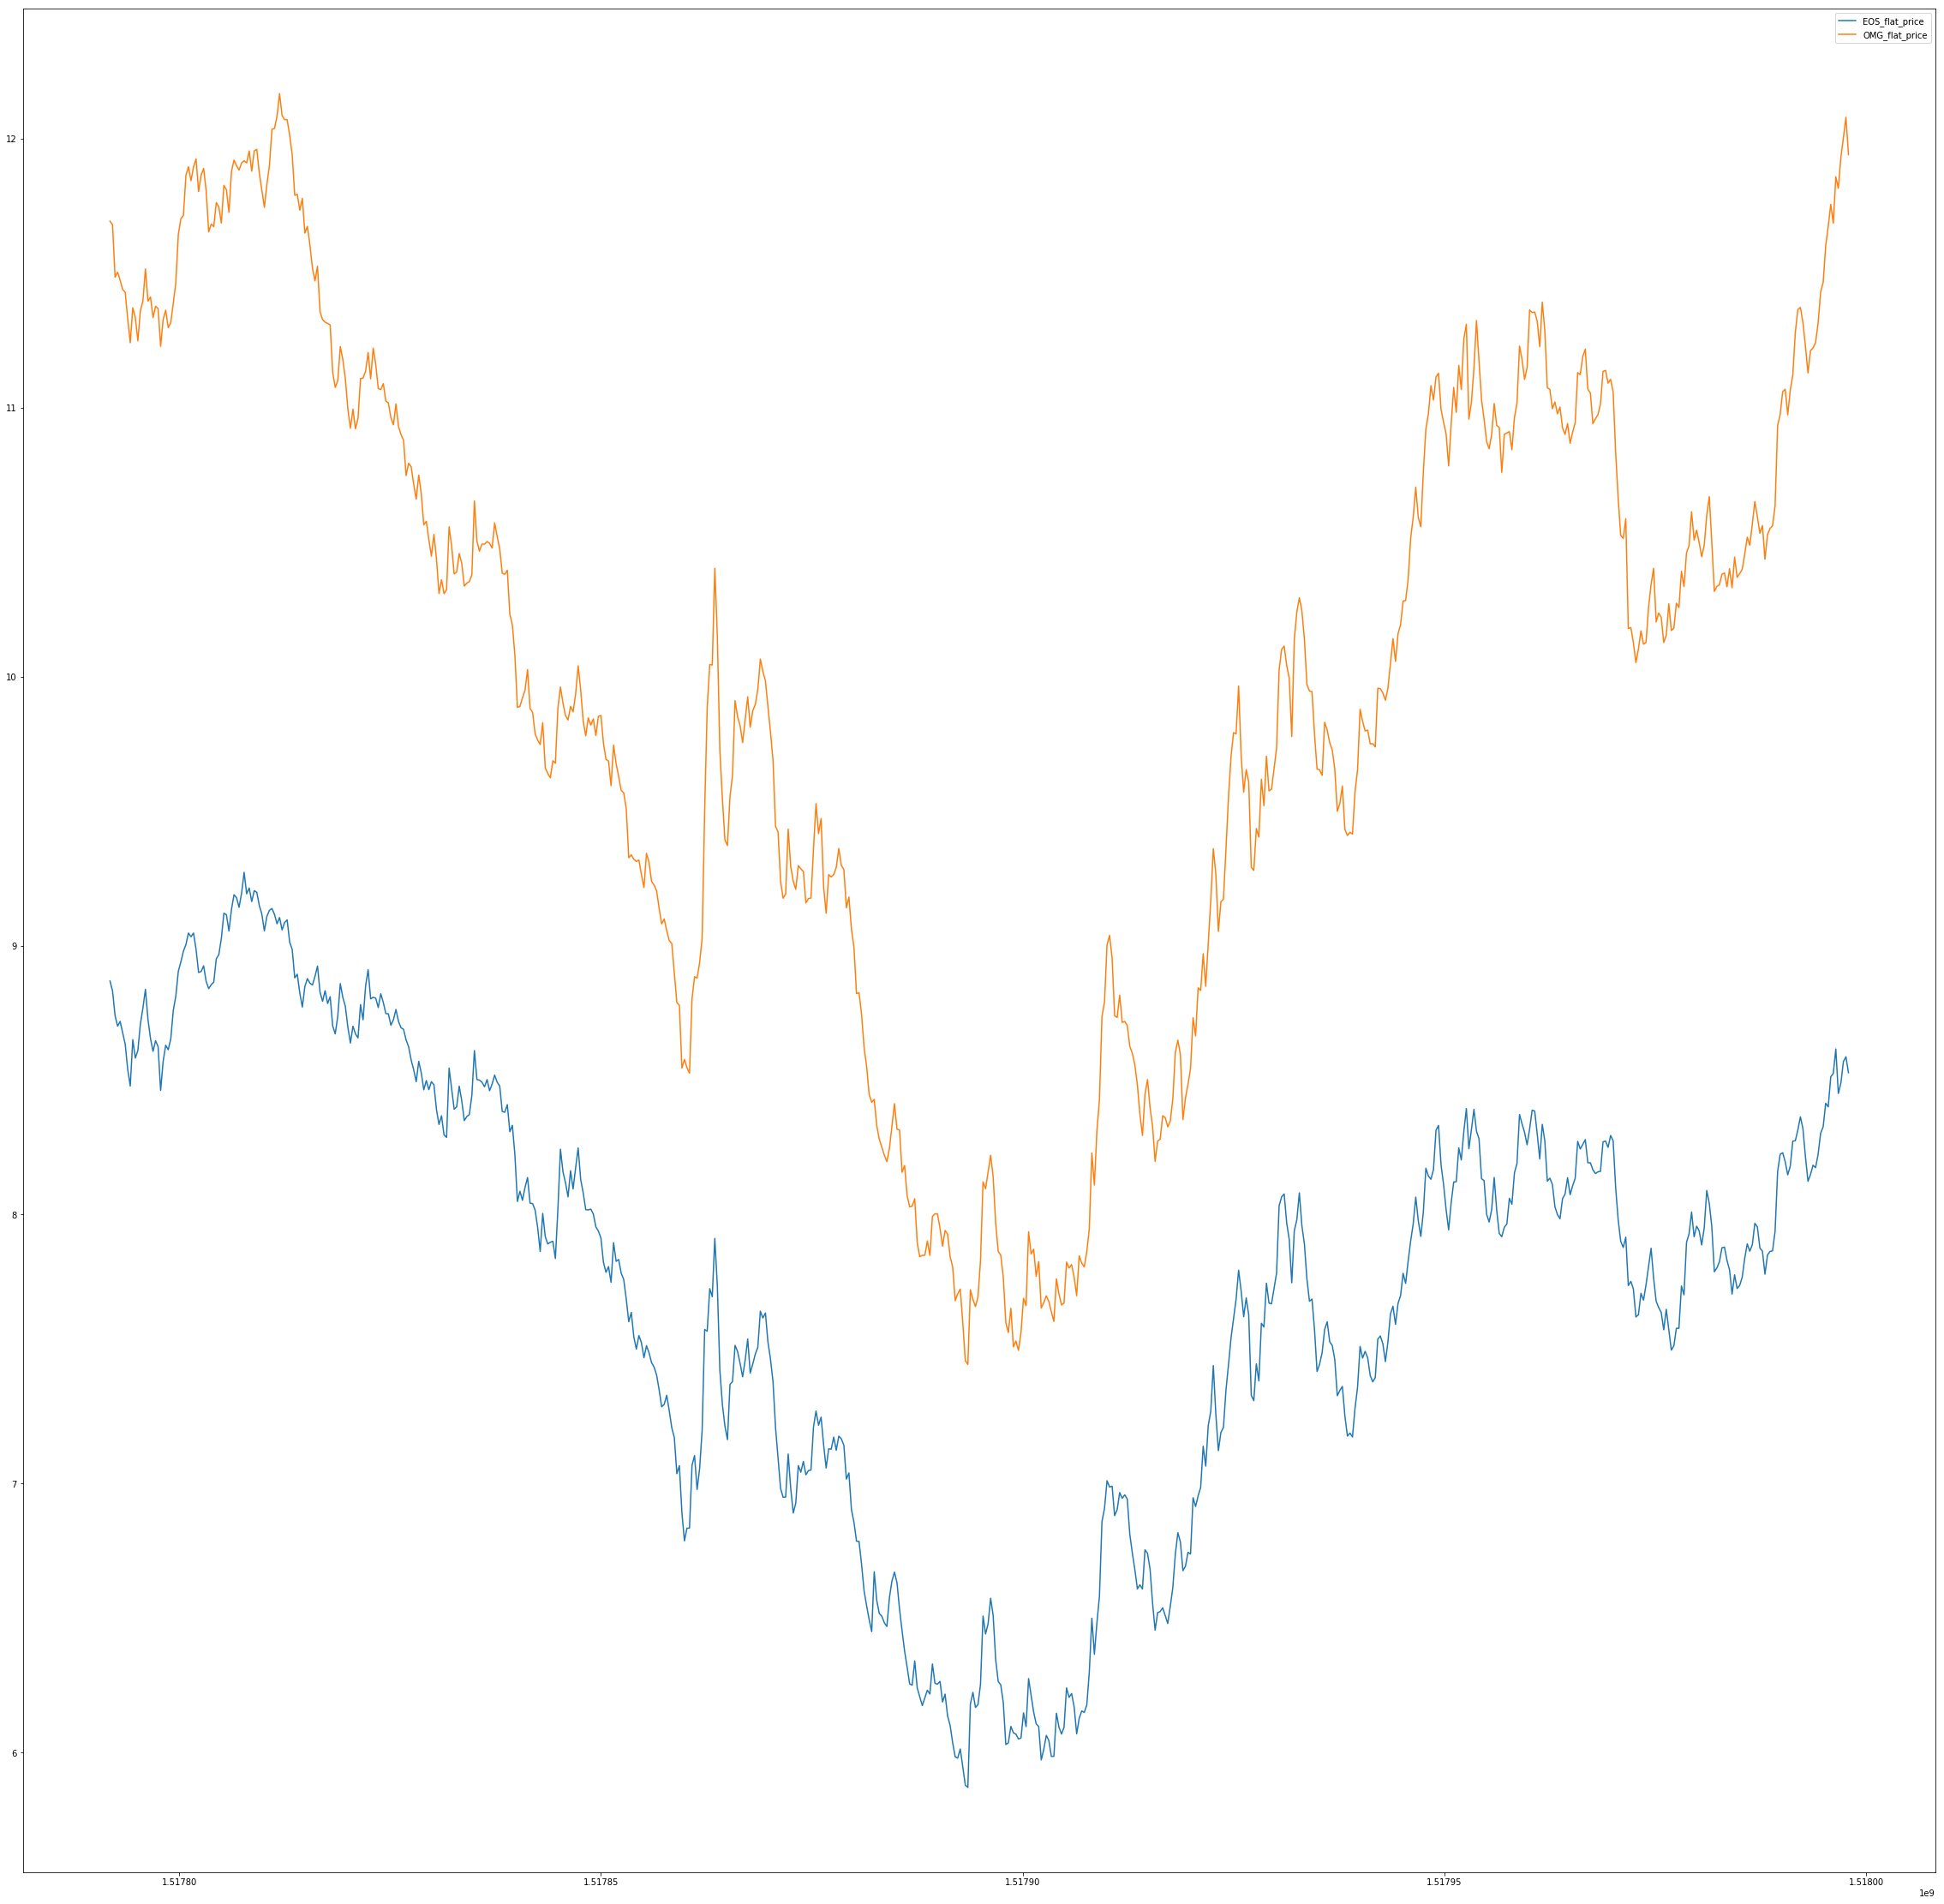

In [15]:
y = [
    'EOS_flat_price', 'OMG_flat_price', 
#    'ntl_OMG_flat_price', 'ntl_EOS_flat_price', 
#    'ntl_flat_price_EOS',
]
# y = ['EOS_flat_price', 'OMG_flat_price', 'ntl_OMG_price', 'ntl_OMG_flat_price']
concated = concated[:]
concated['ntl_flat_price_EOS'] = concated['ntl_flat_price_EOS']
concated.plot(y=y, figsize=(40, 40))

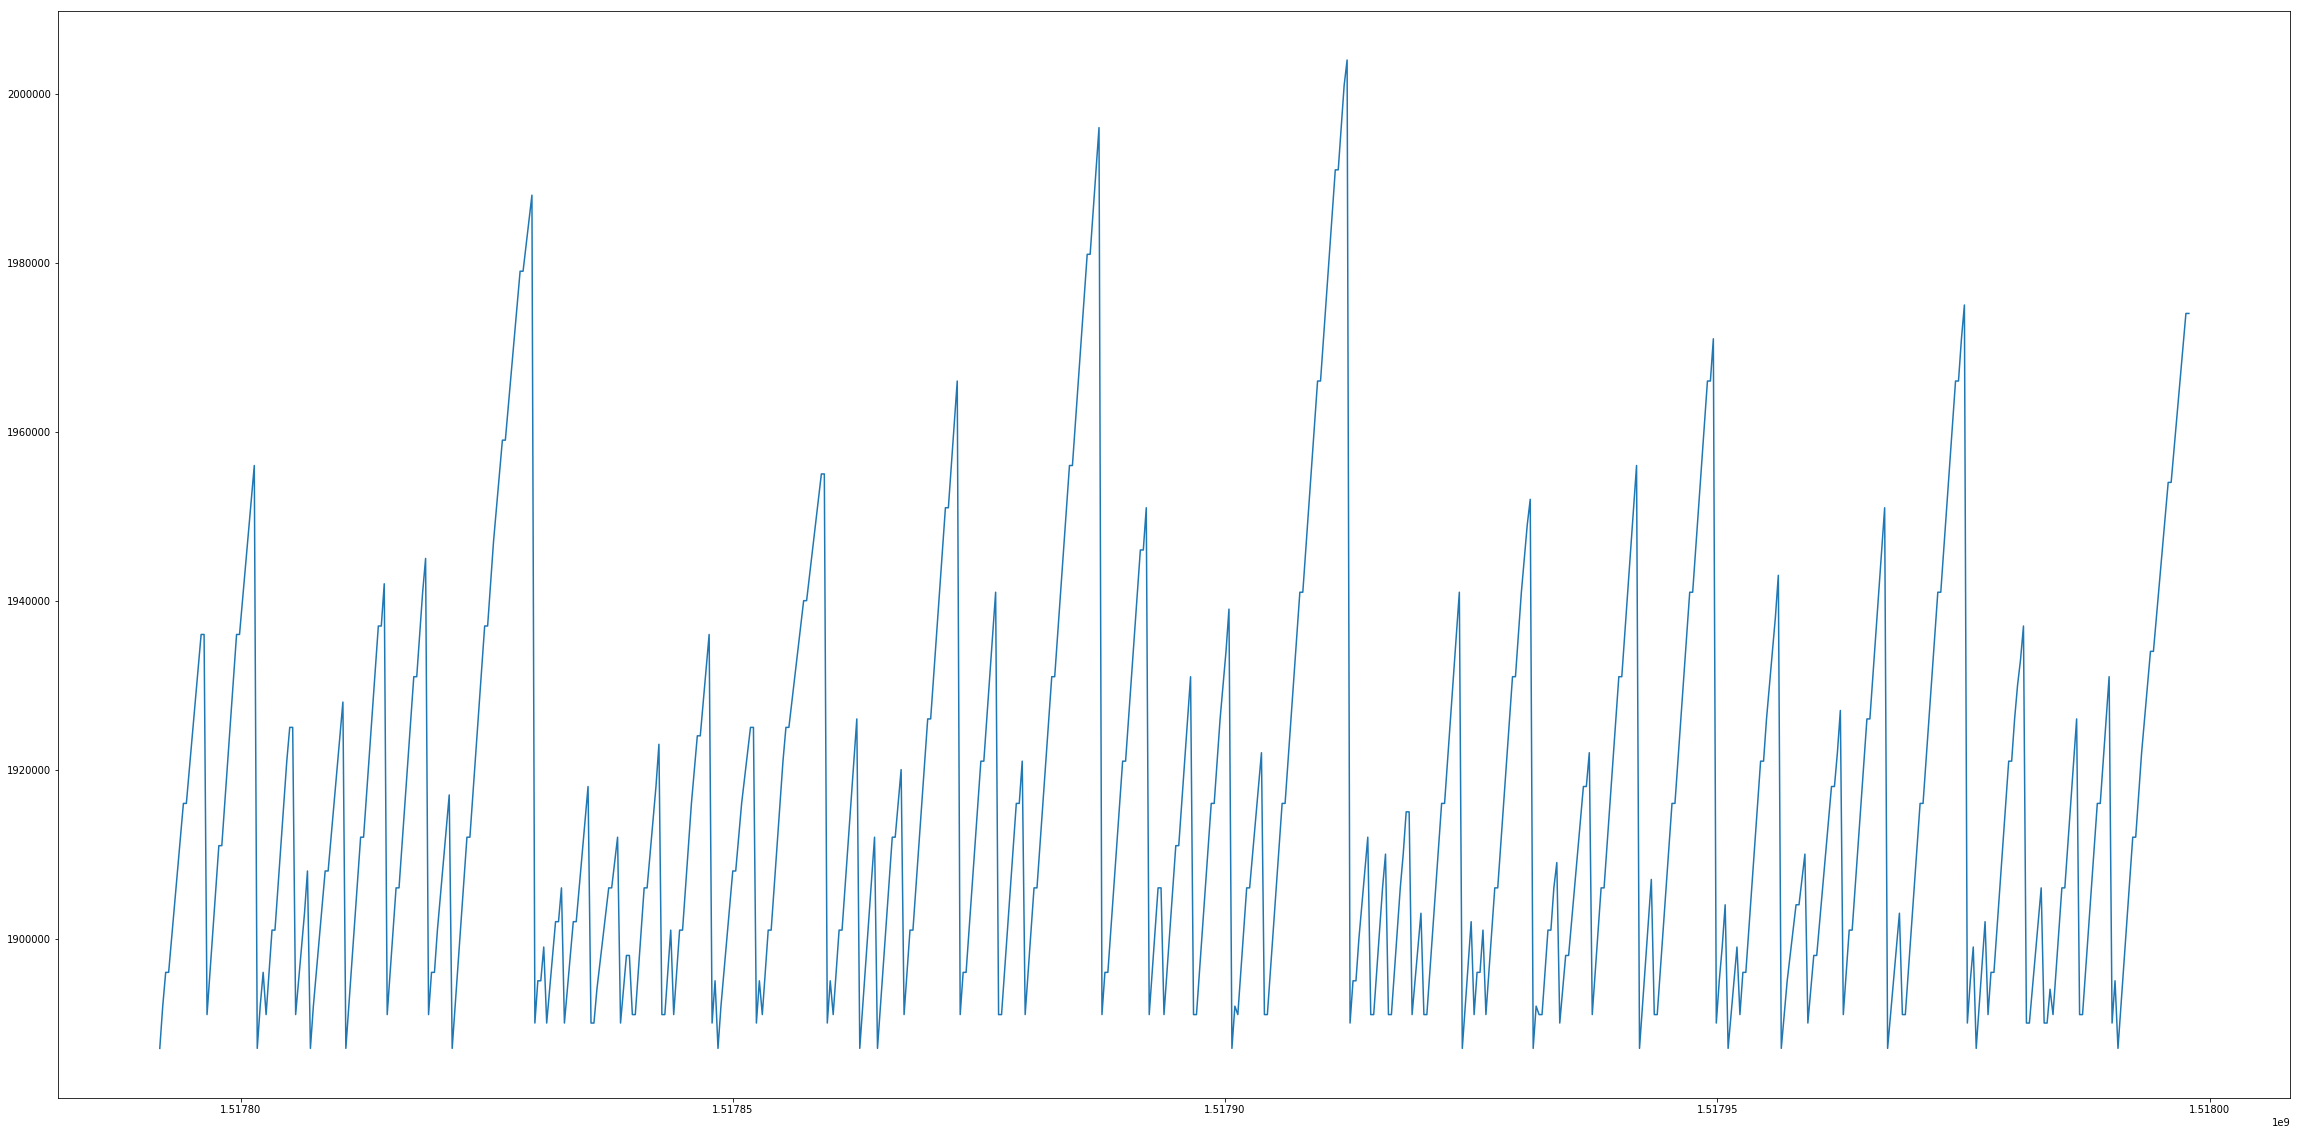

In [16]:
concated['ntl_total_supply_EOS'].plot(figsize=(40, 20))


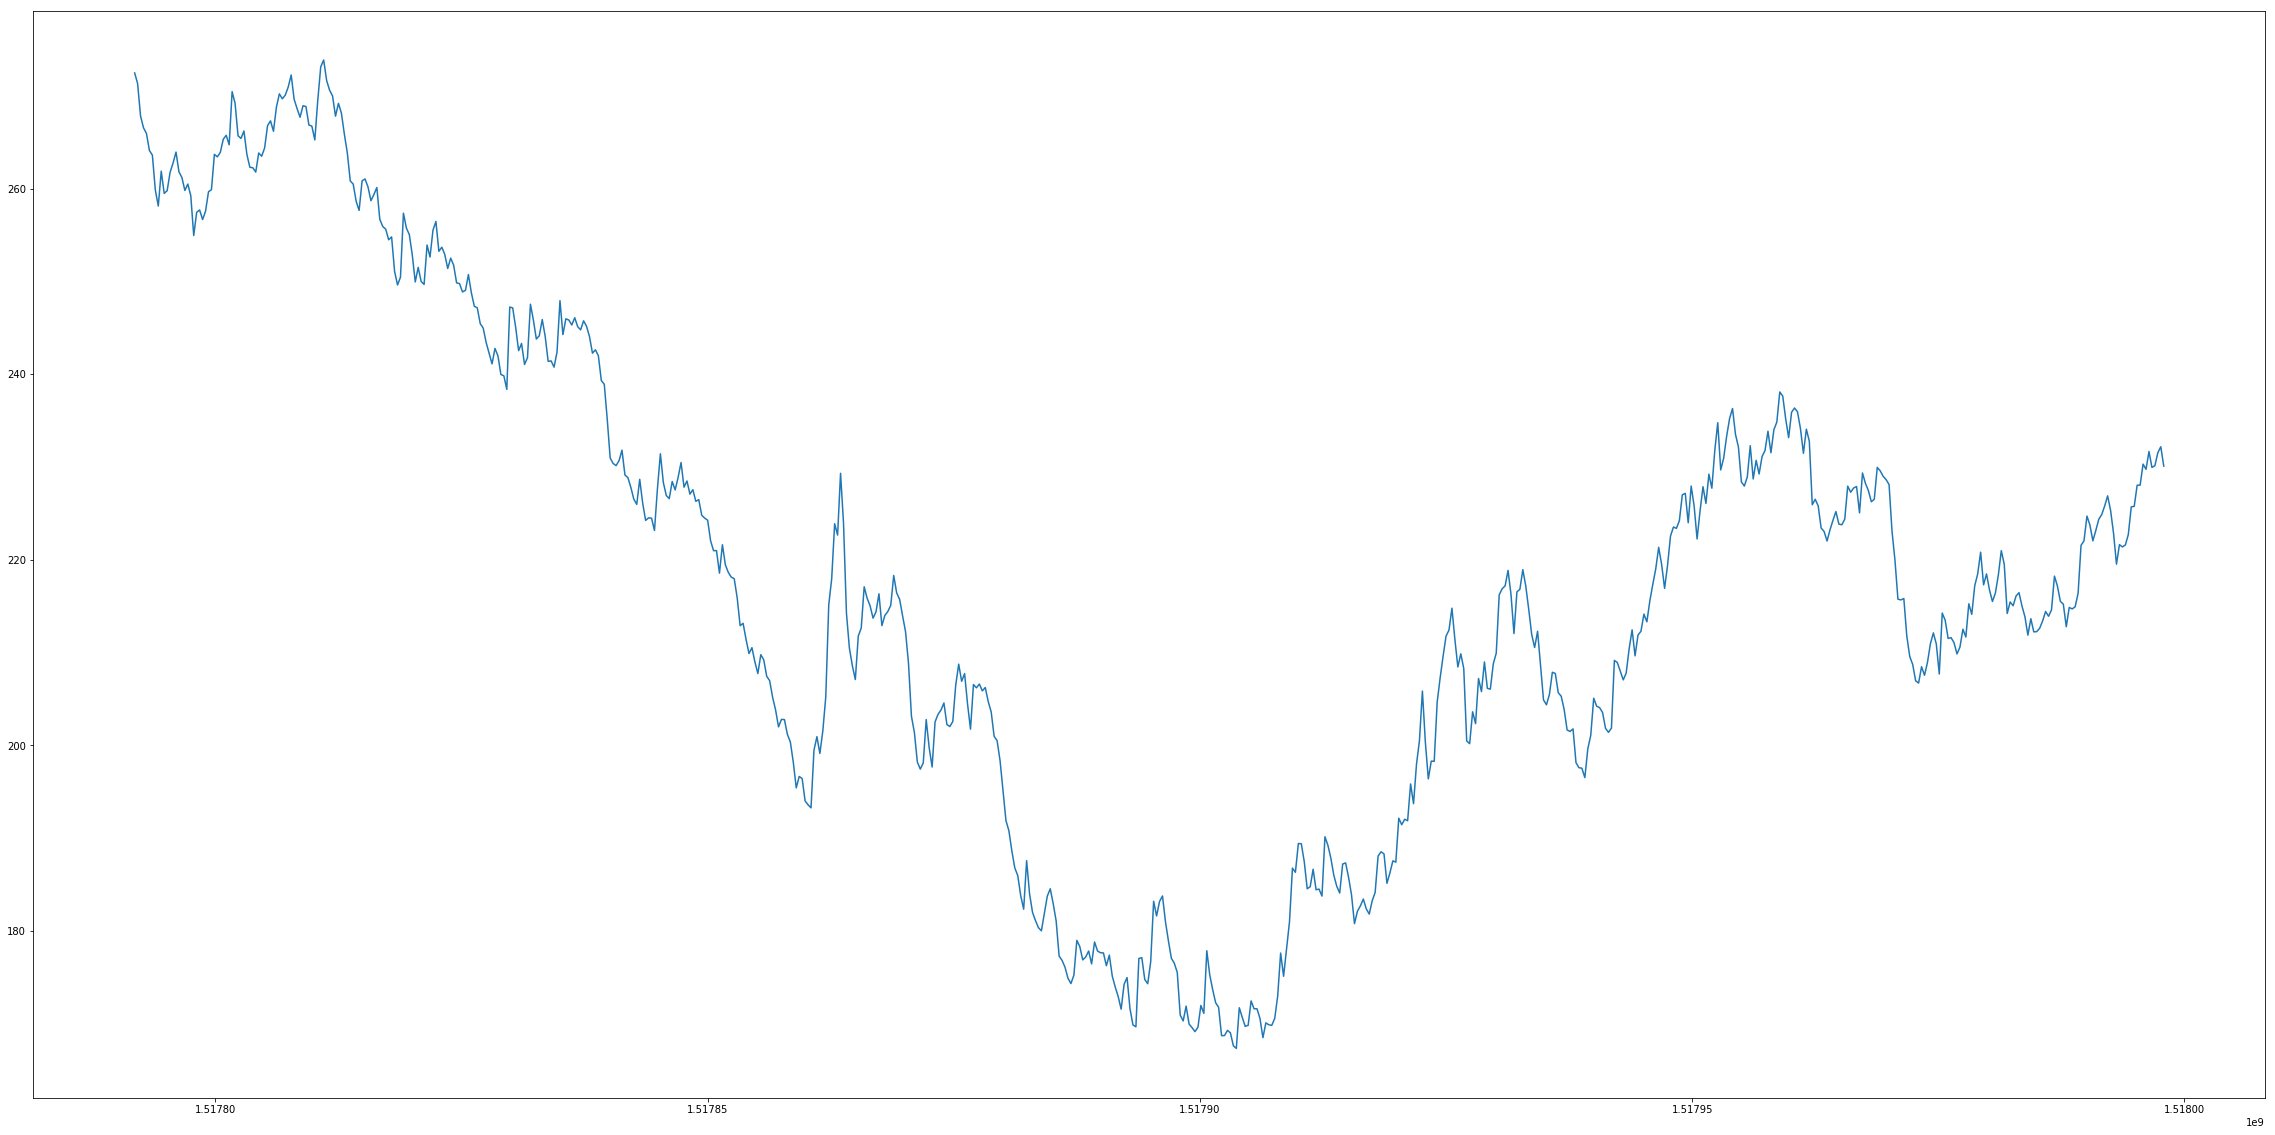

In [17]:
concated['ntl_flat_price_EOS'].plot(figsize=(40, 20))

In [18]:
instances = ['ntl_flat_price_EOS', 'OMG_flat_price', 'EOS_flat_price', 'ntl_total_supply_EOS']
for name in instances:
    print(concated[name].describe())


count    688.000000
mean     218.095702
std       27.284336
min      167.337345
25%      201.061396
50%      216.408657
75%      234.108603
max      273.891623
Name: ntl_flat_price_EOS, dtype: float64
count    688.000000
mean      10.003416
std        1.221575
min        7.443059
25%        9.200708
50%       10.123398
75%       11.015496
max       12.167633
Name: OMG_flat_price, dtype: float64
count    688.000000
mean       7.723441
std        0.848194
min        5.870379
25%        7.141599
50%        7.863049
75%        8.336012
max        9.272370
Name: EOS_flat_price, dtype: float64
count    6.880000e+02
mean     1.916520e+06
std      2.386155e+04
min      1.887000e+06
25%      1.897000e+06
50%      1.911000e+06
75%      1.931000e+06
max      2.004000e+06
Name: ntl_total_supply_EOS, dtype: float64
